In [1]:
import os
import tqdm
import time
import h5py
import random
import argparse
import traceback
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score

root = "/home/zhaoxun/codes/Panda"
warnings.filterwarnings("ignore", category = UserWarning)
global modelpath, plotpath, outpath, starttime


def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    set_all_seed(seed)


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("-f", "--h5", help = "h5 file path", default = "/home/zhaoxun/codes/Panda/_data/v0.h5", type = str)
    parser.add_argument("-M", "--MD", help = "model file", default = "", type = str)
    parser.add_argument("-N", "--nt", help = "net type", default = "resnet34", choices = ["resnet34", "resnext50", *["eff%d" % i for i in range(8)], "resnext50list"], type = str)
    parser.add_argument("-e", "--ep", help = "number of epochs", default = 5, type = int)
    parser.add_argument("-n", "--nc", help = "number of classes", default = 6, type = int)
    # parser.add_argument("-p", "--pt", help = "pretrained", default = True, type = bool)
    parser.add_argument("-l", "--lr", help = "learning rate", default = 1e-3, type = float)
    parser.add_argument("-L", "--ls", help = "loss type", default = "cross", choices = ["cross", "focal"], type = str)
    parser.add_argument("-b", "--bs", help = "batch size", default = 32, type = int)
    # parser.add_argument("-c", "--cb", help = "call-back step size", default = 1, type = int)
    # parser.add_argument("-s", "--ss", help = "learning rate scheduler step size", default = 30, type = int)
    parser.add_argument("-w", "--wd", help = "weight decay", default = 1e-3, type = float)
    # parser.add_argument("-g", "--gp", help = "gpus", default = [0], type = list)
    parser.add_argument("-d", "--dv", help = "visible devices", default = "3", choices = list("0123"), type = str)
    parser.add_argument("-s", "--sm", help = "label smoothing", default = 0.001, type = float)
    parser.add_argument("-m", "--gm", help = "focal loss gamma", default = 2, type = int)
    parser.add_argument("-o", "--op", help = "optim method", default = "sgd", choices = ["sgd", "adam", "over"], type = str)
    parser.add_argument("-B", "--bg", help = "bag iters", default = 0, type = int)
    parser.add_argument("-R", "--br", help = "bag ratio", default = 1, type = float)
    # parser.add_argument("-S", "--sc", help = "learning rate scheduler", default = "cos", type = str)
    return vars(parser.parse_args())


def make_file_path():
    basepath = os.path.split(os.path.realpath(__file__))[0]
    fullpath = os.path.realpath(__file__)
    filename = os.path.split(os.path.realpath(__file__))[1]
    t = time.strftime("%b.%d_%H:%M", time.localtime()) + ".cls"
    os.system("mkdir -p _archives _outs _plots _models; cp %s %s/_archives/%s.py" % (fullpath, basepath, t))
    modelpath = os.path.join(basepath, "_models", "%s.model" % t)
    plotpath = os.path.join(basepath, "_plots", "%s.png" % t)
    outpath = os.path.join(basepath, "_outs", "%s.out" % t)
    return modelpath, plotpath, outpath, t, basepath


def printOut(*args):
    with open(outpath, 'a') as f:
        f.write(' '.join([str(arg) for arg in args]))
        f.write('\n')


# modelpath, plotpath, outpath, starttime, basepath = make_file_path()
params = parse_args()
# printOut("Iafoss using GPU: " + params['dv'])
os.environ["CUDA_VISIBLE_DEVICES"] = params.pop("dv")
from Radam import *
from radam import *
from sklearn.model_selection import StratifiedKFold
from fastai.callbacks import *
from fastai.vision import *
from fastai import *
import PoolTileNet
import torchvision
import torch
# torch.backends.cudnn.benchmark = True
setup_seed(1)
TRAIN = "/home/zhaoxun/codes/Panda/_data/iafoss/train"
LABELS = '/home/zhaoxun/codes/Panda/_data/train.csv'
nfolds = 5
SEED = 1
mean = torch.tensor([1.0-0.90949707, 1.0-0.8188697, 1.0-0.87795304])[..., None, None]
std = torch.tensor([0.36357649, 0.49984502, 0.40477625])[..., None, None]
df = pd.read_csv(LABELS).set_index('image_id')
sz = 128
N = 12

files = sorted(set([p[:32] for p in os.listdir(TRAIN)]))
df = df.loc[files]
df = df.reset_index()
splits = StratifiedKFold(n_splits = nfolds, random_state = SEED, shuffle = True)
splits = list(splits.split(df, df.isup_grade))
folds_splits = np.zeros(len(df)).astype(np.int)
for i in range(nfolds):
    folds_splits[splits[i][1]] = i
df['split'] = folds_splits
# df.head()


def open_image(fn, div = True, convert_mode = 'RGB', cls = Image,after_open = None):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        x = PIL.Image.open(fn).convert(convert_mode)
    if after_open:
        x = after_open(x)
    x = pil2tensor(x, np.float32)
    if div:
        x.div_(255)
    return cls(1.0 - x)


class MImage(ItemBase):
    def __init__(self, imgs):
        self.obj = (imgs)
        self.data = [(imgs[i].data - mean) / std for i in range(len(imgs))]

    def apply_tfms(self, tfms, *args, **kwargs):
        for i in range(len(self.obj)):
            self.obj[i] = self.obj[i].apply_tfms(tfms, *args, **kwargs)
            self.data[i] = (self.obj[i].data - mean) / std
        return self

    def __repr__(self): 
        return f'{self.__class__.__name__} {[img.shape for img in self.obj]}'

    def to_one(self):
        img = torch.stack(self.data, 1)
        img = img.view(3, -1, N, sz, sz).permute(0, 1, 3, 2, 4).contiguous().view(3, -1, sz * N)
        return Image(1.0 - (mean + img * std))


class MImageItemList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __len__(self) -> int: return len(self.items) or 1

    def get(self, i):
        fn = Path(self.items[i])
        fnames = [Path(str(fn) + '_' + str(i) + '.png') for i in range(N)]
        imgs = [open_image(fname, convert_mode = self.convert_mode, after_open = self.after_open) for fname in fnames]
        return MImage(imgs)

    def reconstruct(self, t):
        return MImage([mean + _t * std for _t in t])

    def show_xys(self, xs, ys, figsize = (300, 50), **kwargs):
        rows = min(len(xs), 8)
        fig, axs = plt.subplots(rows, 1, figsize = figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax = ax, y = ys[i], **kwargs)
        plt.tight_layout()


# collate function to combine multiple images into one tensor
def MImage_collate(batch: ItemsList):
    result = torch.utils.data.dataloader.default_collate(to_data(batch))
    if isinstance(result[0], list):
        result = [torch.stack(result[0], 1), result[1]]
    return result


def get_data(bs, bg = None, br = 0.8):
    trainidx = df.index[df.split != 0].tolist()
    if bg is not None: trainidx = np.random.choice(trainidx, round(len(trainidx) * br), replace = False)
    validx = df.index[df.split == 0].tolist()
    return (MImageItemList.from_df(df, path = '/', folder = TRAIN, cols = 'image_id')
            .split_by_idxs(trainidx, validx)
            .label_from_df(cols = ['isup_grade'])
            .transform(get_transforms(flip_vert = True, max_rotate = 15), size = sz, padding_mode = 'zeros')
            .databunch(bs = bs, num_workers = 4))




Bad key "text.kerning_factor" on line 4 in
/data/zhaoxun/miniconda3/envs/torch/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [6]:
class Train(object):
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        # self.data = Data(kwargs['h5'])

        # model
        if kwargs['nt'] == "resnet34":
            self.net = PoolTileNet.PoolTileNetList(kwargs["nc"])
        elif kwargs['nt'] == "resnext50":
            self.net = PoolTileNet.SemiResNextList(n = kwargs['nc'])
        elif kwargs['nt'].startswith("eff"):
            self.net = PoolTileNet.MyEfficientNetReg(
                kwargs['nc'], kwargs['nt'][-1])

        self.net = self.net.cuda()
        if kwargs['MD']:
            dic = torch.load(kwargs['MD'])
            self.net.load_state_dict(dic)

        # loss
        if kwargs['ls'] == "focal":
            self.loss = PoolTileNet.FocalSmoothLoss(
                kwargs['nc'], kwargs['sm'], kwargs['gm'])
        elif kwargs['ls'] == "cross":
            self.loss = torch.nn.CrossEntropyLoss()
        elif kwargs['ls'] == "mse":
            self.loss = torch.nn.MSELoss()

        if kwargs['op'] == "sgd":
            self.opt = torch.optim.SGD
        elif kwargs['op'] == "adam":
            self.opt = RAdam
        elif kwargs['op'] == "over":
            self.opt = Over9000

    class callback(LearnerCallback):
        def __init__(self, ln):
            self.ln = ln
            self.losses = {"train": [], "val": []}

        @property
        def header(self):
            return self.ln.recorder.names

        def on_epoch_end(self, epoch, smooth_loss, last_metrics, **kwargs):
            self.losses['train'].append(float(smooth_loss))
            self.losses['val'].append(float(last_metrics[0]))
            self.write_stats([epoch, smooth_loss] + last_metrics)

        def write_stats(self, stats):
            printOut(
                "{:3d} | tr: {:.3f} | vl: {:.3f} | kp: {:.3f}".format(*stats))

        def on_train_end(self, **kwargs):
            plt.plot(self.losses['train'], label = "train")
            plt.plot(self.losses['val'], label = "val")
            plt.legend()
            plt.savefig(plotpath)

    def evaluations(self, ln):
        pred, target = [], []
        ln.model.eval()
        models = [ln.model]
        with torch.no_grad():
            for step, (x, y) in progress_bar(enumerate(ln.data.dl(DatasetType.Valid)), total = len(ln.data.dl(DatasetType.Valid))):
                bs = len(x[0])
                x = [torch.stack([x, 
                    x.flip(-1), x.flip(-2), x.flip(-1, -2),
                    x.transpose(-1, -2), x.transpose(-1, -2).flip(-1),
                    x.transpose(-1, -2).flip(-2), 
                    x.transpose(-1, -2).flip(-1, -2)], 
                    1).view(-1, *x.shape[1:]) for x in x]
                p = [model(*x) for model in models]
                p = torch.stack(p, 1)
                p = p.view(bs, 8 * len(models), -1).mean(1)
                pred.append(p.float().cpu())
                target.append(y.cpu())
        p = torch.argmax(torch.cat(pred, 0), 1)
        t = torch.cat(target)
        printOut("Val kappa: %.5f" %
                 cohen_kappa_score(t, p, weights = 'quadratic'))
        printOut(confusion_matrix(t, p))

    def train(self):
        dl = get_data(self.kwargs['bs'])
        ln = Learner(
            dl, self.net, 
            loss_func = self.loss, 
            opt_func = self.opt, 
            metrics = [KappaScore(weights = 'quadratic')], 
            bn_wd = False, wd = self.kwargs['wd']
            ).to_fp16()
        ln.clip_grad = 1.0
        ln.split([self.net.head])
        ln.unfreeze()
        cb = self.callback(ln)
        ln.fit_one_cycle(
            self.kwargs['ep'], 
            max_lr = self.kwargs['lr'],
            div_factor = 100, 
            pct_start = 0.3, 
            # wd = [self.kwargs['wd'] / 10, self.kwargs['wd']], 
            wd = self.kwargs['wd'], 
            callbacks = [cb])
        torch.save(self.net.state_dict(), modelpath)
        self.evaluations(ln)


In [7]:
params['nt'] = "eff0"
params['op'] = "over"
params['ls'] = "mse"
self = Train(**params)

Loaded pretrained weights for efficientnet-b0


In [8]:
dl = get_data(self.kwargs['bs'])
ln = Learner(dl, self.net, loss_func = self.loss, opt_func = self.opt, metrics = [KappaScore(weights = 'quadratic')], bn_wd = False, wd = self.kwargs['wd']).to_fp16()

In [9]:
ln.model_dir = "/home/zhaoxun/codes/Panda/models"
ln.lr_find(wd = 1e-3)

epoch,train_loss,valid_loss,kappa_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: expected dtype Float but got dtype Long (validate_dtype at /opt/conda/conda-bld/pytorch_1587428270644/work/aten/src/ATen/native/TensorIterator.cpp:143)
frame #0: c10::Error::Error(c10::SourceLocation, std::string const&) + 0x4e (0x7f43c0462b5e in /data/zhaoxun/miniconda3/envs/torch/lib/python3.6/site-packages/torch/lib/libc10.so)
frame #1: at::TensorIterator::compute_types() + 0xce3 (0x7f43ebdec793 in /data/zhaoxun/miniconda3/envs/torch/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #2: at::TensorIterator::build() + 0x44 (0x7f43ebdef174 in /data/zhaoxun/miniconda3/envs/torch/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #3: at::native::mse_loss_backward_out(at::Tensor&, at::Tensor const&, at::Tensor const&, at::Tensor const&, long) + 0x193 (0x7f43ebc3d1a3 in /data/zhaoxun/miniconda3/envs/torch/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #4: <unknown function> + 0xdf46a7 (0x7f43c14836a7 in /data/zhaoxun/miniconda3/envs/torch/lib/python3.6/site-packages/torch/lib/libtorch_cuda.so)
frame #5: at::native::mse_loss_backward(at::Tensor const&, at::Tensor const&, at::Tensor const&, long) + 0x172 (0x7f43ebc458e2 in /data/zhaoxun/miniconda3/envs/torch/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #6: <unknown function> + 0xdf495f (0x7f43c148395f in /data/zhaoxun/miniconda3/envs/torch/lib/python3.6/site-packages/torch/lib/libtorch_cuda.so)
frame #7: <unknown function> + 0xe22286 (0x7f43ec075286 in /data/zhaoxun/miniconda3/envs/torch/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #8: <unknown function> + 0x27fd2fb (0x7f43eda502fb in /data/zhaoxun/miniconda3/envs/torch/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #9: <unknown function> + 0xe22286 (0x7f43ec075286 in /data/zhaoxun/miniconda3/envs/torch/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #10: torch::autograd::generated::MseLossBackward::apply(std::vector<at::Tensor, std::allocator<at::Tensor> >&&) + 0x1f7 (0x7f43ed857d97 in /data/zhaoxun/miniconda3/envs/torch/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #11: <unknown function> + 0x2ae8215 (0x7f43edd3b215 in /data/zhaoxun/miniconda3/envs/torch/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #12: torch::autograd::Engine::evaluate_function(std::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&) + 0x16f3 (0x7f43edd38513 in /data/zhaoxun/miniconda3/envs/torch/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #13: torch::autograd::Engine::thread_main(std::shared_ptr<torch::autograd::GraphTask> const&, bool) + 0x3d2 (0x7f43edd392f2 in /data/zhaoxun/miniconda3/envs/torch/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #14: torch::autograd::Engine::thread_init(int) + 0x39 (0x7f43edd31969 in /data/zhaoxun/miniconda3/envs/torch/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #15: torch::autograd::python::PythonEngine::thread_init(int) + 0x38 (0x7f43f1077c38 in /data/zhaoxun/miniconda3/envs/torch/lib/python3.6/site-packages/torch/lib/libtorch_python.so)
frame #16: <unknown function> + 0xc819d (0x7f4438f2819d in /data/zhaoxun/miniconda3/envs/torch/lib/python3.6/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6)
frame #17: <unknown function> + 0x76db (0x7f443bf306db in /lib/x86_64-linux-gnu/libpthread.so.0)
frame #18: clone + 0x3f (0x7f443bc5988f in /lib/x86_64-linux-gnu/libc.so.6)


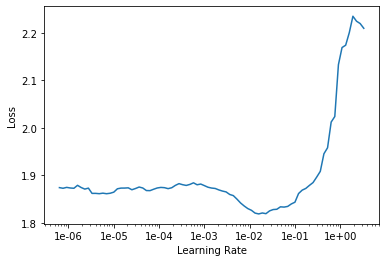

In [10]:
ln.recorder.plot()

In [11]:
params

{'h5': '/home/zhaoxun/.local/share/jupyter/runtime/kernel-35aefdc7-5f29-4151-b78c-23d7d1e2990d.json',
 'MD': '',
 'nt': 'eff0',
 'ep': 5,
 'nc': 6,
 'lr': 0.001,
 'ls': 'cross',
 'bs': 32,
 'wd': 0.001,
 'sm': 0.001,
 'gm': 2,
 'op': 'over',
 'bg': 0,
 'br': 1}